In [1]:
import numpy as np
import jax.numpy as jnp
import scipy.sparse as ss
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from jax import jit, vmap
from stable_baselines3 import A2C

from src.fem import Graph
from src.envs import EigEnv, GraphEnv
from const import *
from util import *

In [2]:

@jit
def f(x):
    return x[0]**2 + x[1]**2 + 1

@jit
def g(x):
    return x[0] + x[1]

@jit
def primjer(x):
    return (4*jnp.pi**2+1)*jnp.sin(2*jnp.pi*x[0])

A = ss.coo_array(
    np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [-1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
              [0, -1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
              [0, 0, -1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
              [0, 0, 0, -1, 0, -1, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, -1, 0, 0, -1, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, -1, 0, -1, 0, 0, 1],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1]], 
             dtype=int)) # cube

featA = np.array([[0, 0, 0],
                 [1, 0, 0],
                 [0, 1, 0],
                 [0, 0, 1],
                 [1, 1, 0],
                 [1, 0, 1],
                 [0, 1, 1],
                 [1, 1, 1]])

B = ss.coo_array(
    np.array([[1, 1, 1, 1],
              [-1, 0, 0, 0],
              [0, -1, 0, 0],
              [0, 0, -1, 0],
              [0, 0, 0, -1]], 
             dtype=int)) # cross

featB = np.array([[0, 0, 0],
                  [-1, 0, 0],
                  [0, -1, 0],
                  [1, 0, 0],
                  [0, 1, 0]])

C = ss.coo_array(
    np.array([[1, 0, 0, -1],
              [-1, 1, 0, 0],
              [0, -1, 1, 0],
              [0, 0, -1, 1]], 
             dtype=int)) # square

featC = np.array([[0, 1, 0],
                  [-1, 0, 0],
                  [0, -1, 0],
                  [1, 0, 0]])

D = ss.coo_array(
    np.array([[1, 1],
              [-1, 0],
              [0, -1]],
             dtype=int)) # ortho

featD = np.array([[0, 0, 0],
                  [-1, 0, 0],
                  [0, -1, 0]])

E = ss.coo_array(np.array([
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 
    [-1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0],
    [0, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, -1]], dtype=int)) # graphene

featE = np.array([[2.       , 1.       , 0.       ],
       [1.5      , 1.8660254, 0.       ],
       [0.5      , 1.8660254, 0.       ],
       [0.       , 1.       , 0.       ],
       [0.5      , 0.1339746, 0.       ],
       [1.5      , 0.1339746, 0.       ],
       [5.       , 1.       , 0.       ],
       [4.5      , 1.8660254, 0.       ],
       [3.5      , 1.8660254, 0.       ],
       [3.       , 1.       , 0.       ],
       [3.5      , 0.1339746, 0.       ],
       [4.5      , 0.1339746, 0.       ]])

In [32]:
def crtaj_fun(T):
    legend_elements = []
    legend_elements.append(Line2D([0], [0], color='green', marker='', 
                                   label='Linear approximation'))
    legend_elements.append(Line2D([0], [0], color='blue', marker='.', linestyle='', 
                                   label='Discretization nodes'))
    legend_elements.append(Line2D([0], [0], color='red', marker='o', linestyle='', 
                                   label='Solutions in nodes'))
    fig = plt.figure(figsize=[14, 14])
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(T.coord[:, 0][:T.vcnt],
           T.coord[:, 1][:T.vcnt],
           T.coord[:, 2][:T.vcnt], s=15, c='blue')

    ax.scatter(T.coord[:, 0][:T.vcnt],
               T.coord[:, 1][:T.vcnt],
               T.u, s=25, c='red')
    plt.title(f'{T.ecnt} elements')
    for i in range(T.ecnt):
        t = T.E[:, [i]].indices
        ax.plot([T.coord[t[0]][0], T.coord[t[1]][0]],
                [T.coord[t[0]][1], T.coord[t[1]][1]],
                [T.u[t[0]], T.u[t[1]]],
                c='green')

    ax.legend(handles=legend_elements)

def crtaj_eig(T):
    legend_elements = []
    legend_elements.append(Line2D([0], [0], color='green', marker='', 
                                   label='Linear approximation'))
    legend_elements.append(Line2D([0], [0], color='blue', marker='.', linestyle='', 
                                   label='Discretization nodes'))
    legend_elements.append(Line2D([0], [0], color='red', marker='o', linestyle='', 
                                   label='Solutions in nodes'))
    fig = plt.figure(figsize=[14, 14])
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(T.coord[:, 0][:T.vcnt],
           T.coord[:, 1][:T.vcnt],
           T.coord[:, 2][:T.vcnt], s=15, c='blue')

    ax.scatter(T.coord[:, 0][:T.vcnt],
               T.coord[:, 1][:T.vcnt],
               T.u, s=25, c='red')
    plt.title(f'Eigenvalue {np.real(T.svoj[T.eig]):.4f}, {T.ecnt} elements')
    for i in range(T.ecnt):
        t = T.E[:, [i]].indices
        ax.plot([T.coord[t[0]][0], T.coord[t[1]][0]],
                [T.coord[t[0]][1], T.coord[t[1]][1]],
                [T.u[t[0]], T.u[t[1]]],
                c='green')
    mn = np.min(T.coord)
    mx = np.max(T.coord)
    ax.set_xlim(mn, mx)
    ax.set_ylim(mn, mx)
    ax.legend(handles=legend_elements)

We will train our agent on 10 graphs which represent eigenvectors that correspond to the 10 smallest eigenvalues of 
<br>
<center>
$$-u'' = \lambda u$$
</center>
<br>
on the following graph:

Text(0.5, 1.0, 'Graph')

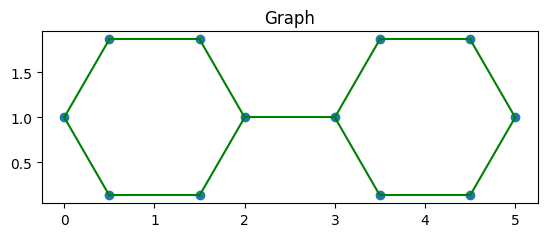

In [36]:
T = Graph(E, featE)
fig = plt.figure()
ax = fig.add_subplot()
ax.set_aspect('equal')
ax.scatter(T.coord[:, 0][:T.vcnt], 
           T.coord[:, 1][:T.vcnt])
for i in range(T.ecnt):
        t = T.E[:, [i]].indices
        ax.plot([T.coord[t[0]][0], T.coord[t[1]][0]],
                [T.coord[t[0]][1], T.coord[t[1]][1]],
                c='green')
plt.title('Graph')

In [37]:
T = Graph(E, featE)

for _ in range(5):
    for i in range(T.ecnt):
        T.refine(i)
T.calculate_eigen()

/home/mislav/miniconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 640x480 with 0 Axes>

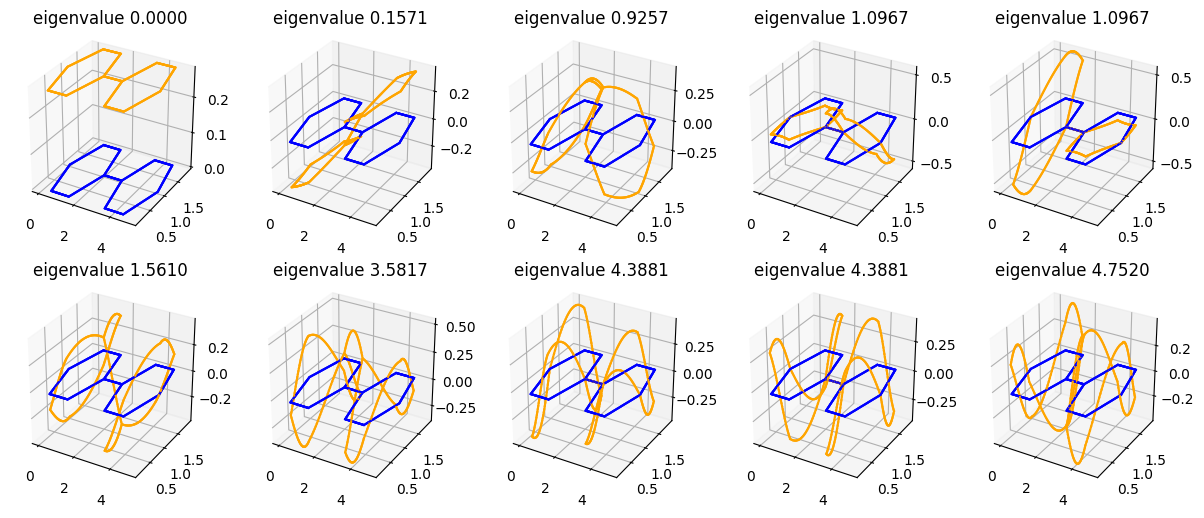

In [6]:
fig = plt.figure()
fig, axs = plt.subplots(2, 5, figsize=(15, 6), subplot_kw={'projection': '3d'})
for ax in axs.flatten():
    ax.set_aspect('equal')
for j in range(10):
    for i in range(T.ecnt):
        t = T.E[:, [i]].indices
        axs[j//5, j%5].set_title(f'eigenvalue {np.real(T.svoj[j]):.4f}')
        axs[j//5, j%5].plot([T.coord[t[0]][0], T.coord[t[1]][0]],
                [T.coord[t[0]][1], T.coord[t[1]][1]],
                [T.svi[:, j][t[0]], T.svi[:, j][t[1]]],
                c='orange')
        axs[j//5, j%5].plot([T.coord[t[0]][0], T.coord[t[1]][0]],
                [T.coord[t[0]][1], T.coord[t[1]][1]],
                [0, 0],
                c='blue')

In [7]:
env = EigEnv(E, featE)
# model = A2C("MlpPolicy", env, verbose=1, tensorboard_log="./tensorboard/")
# model.learn(total_timesteps=1_000_000)
# model.save('params/a2c')

model = A2C.load('params/a2c')

We give it 30 elements and 150 actions to optimize the approximation.

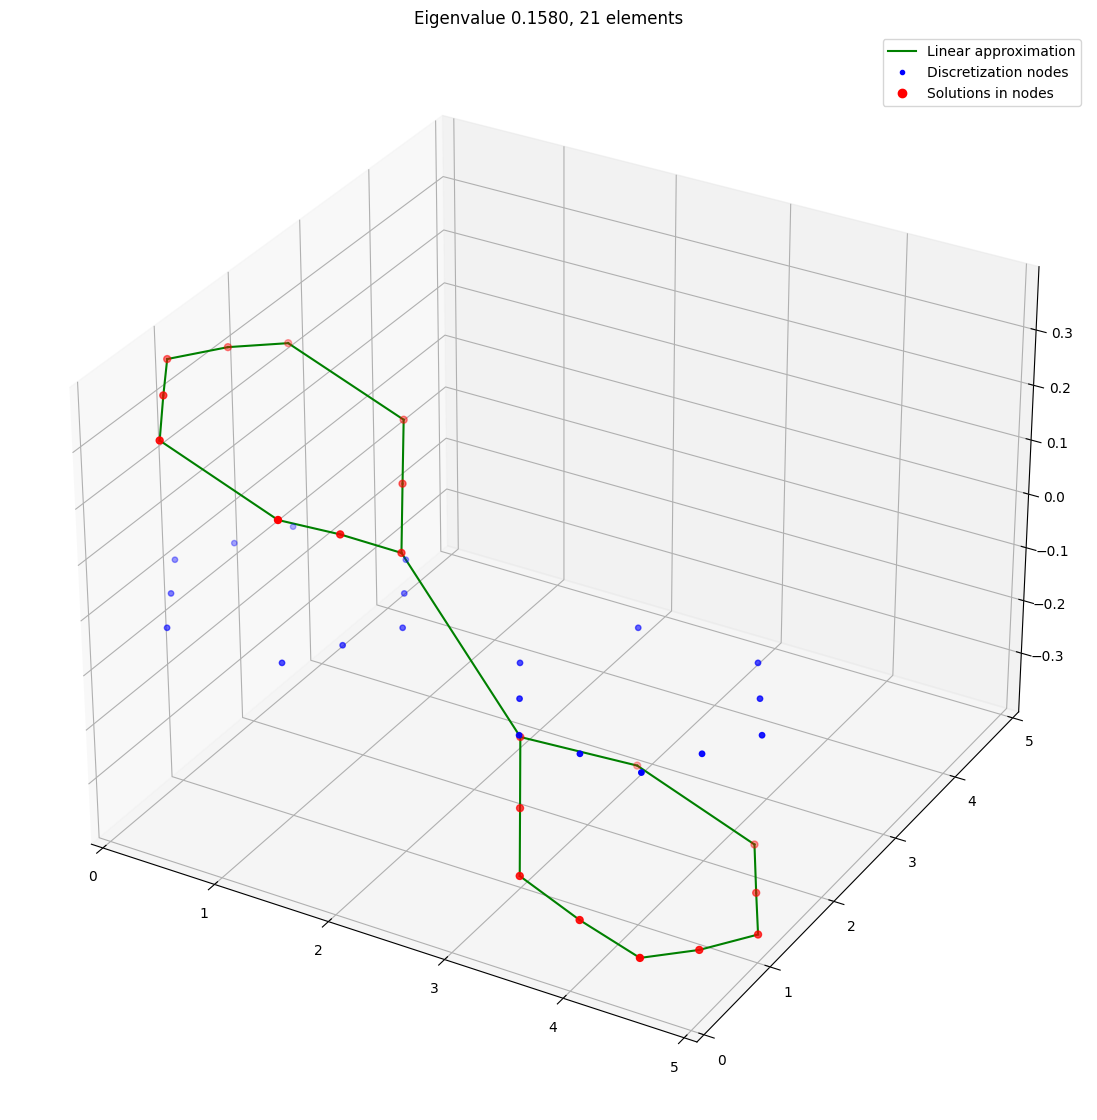

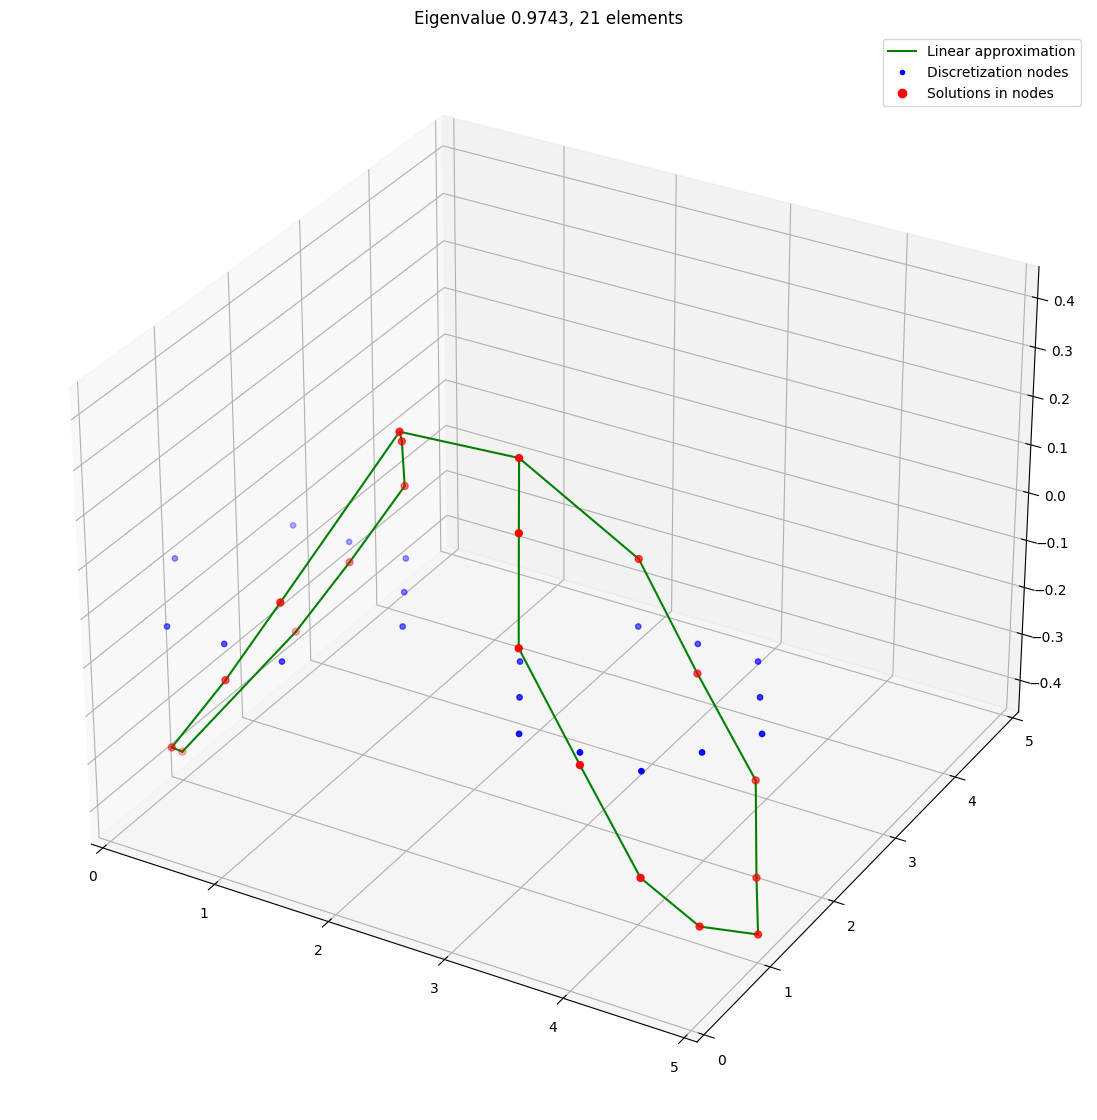

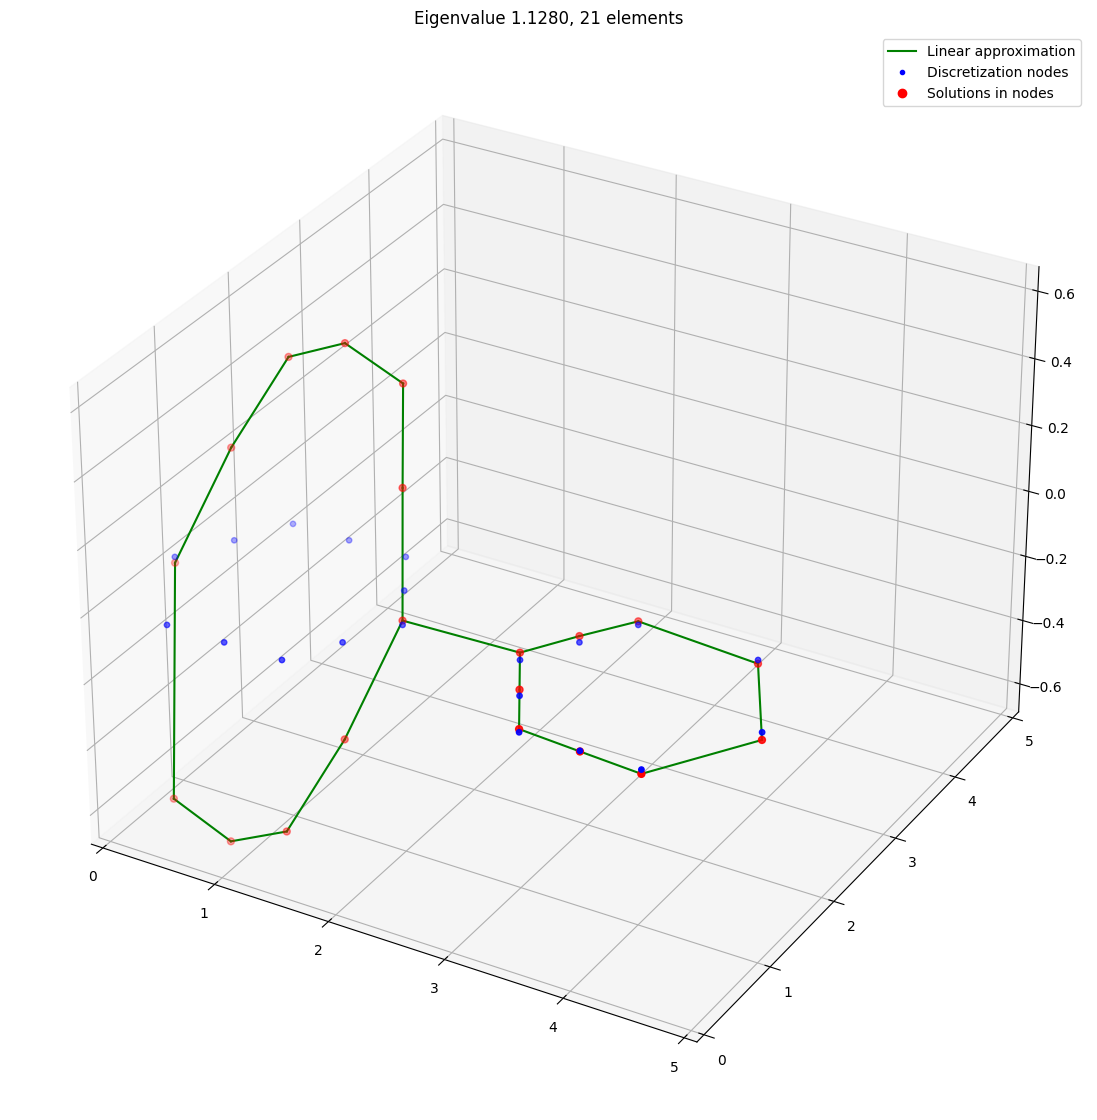

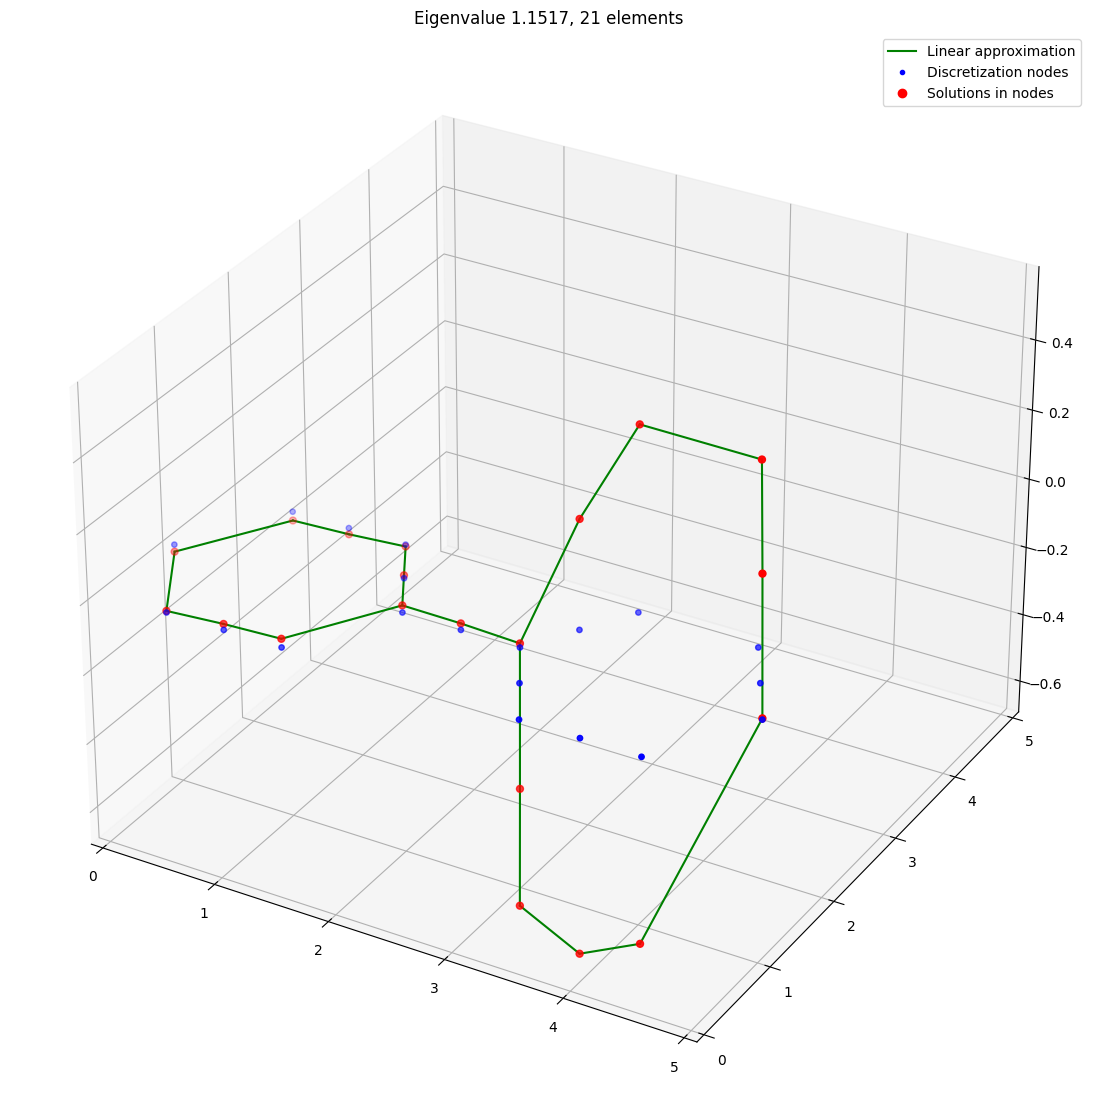

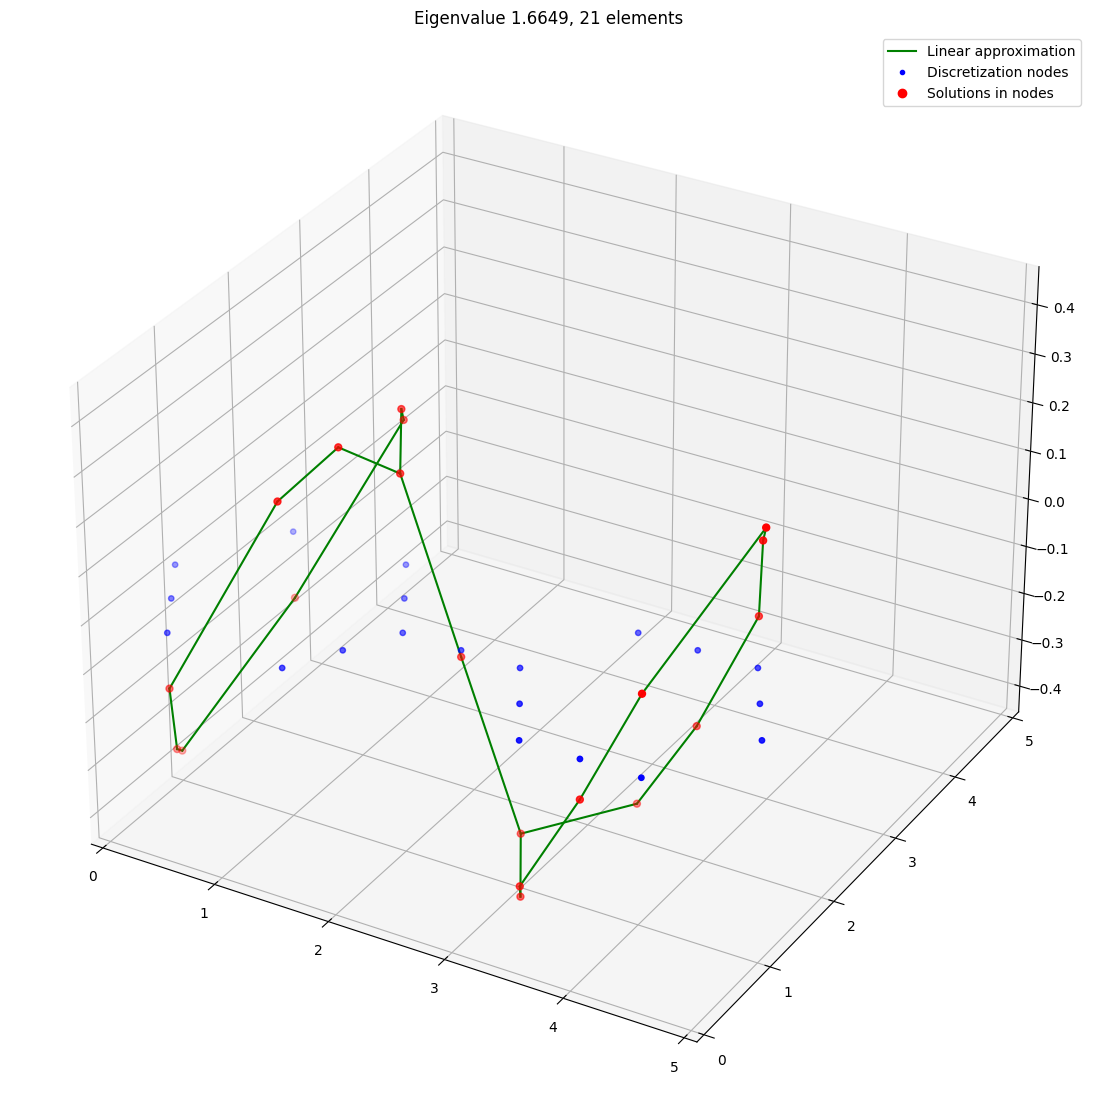

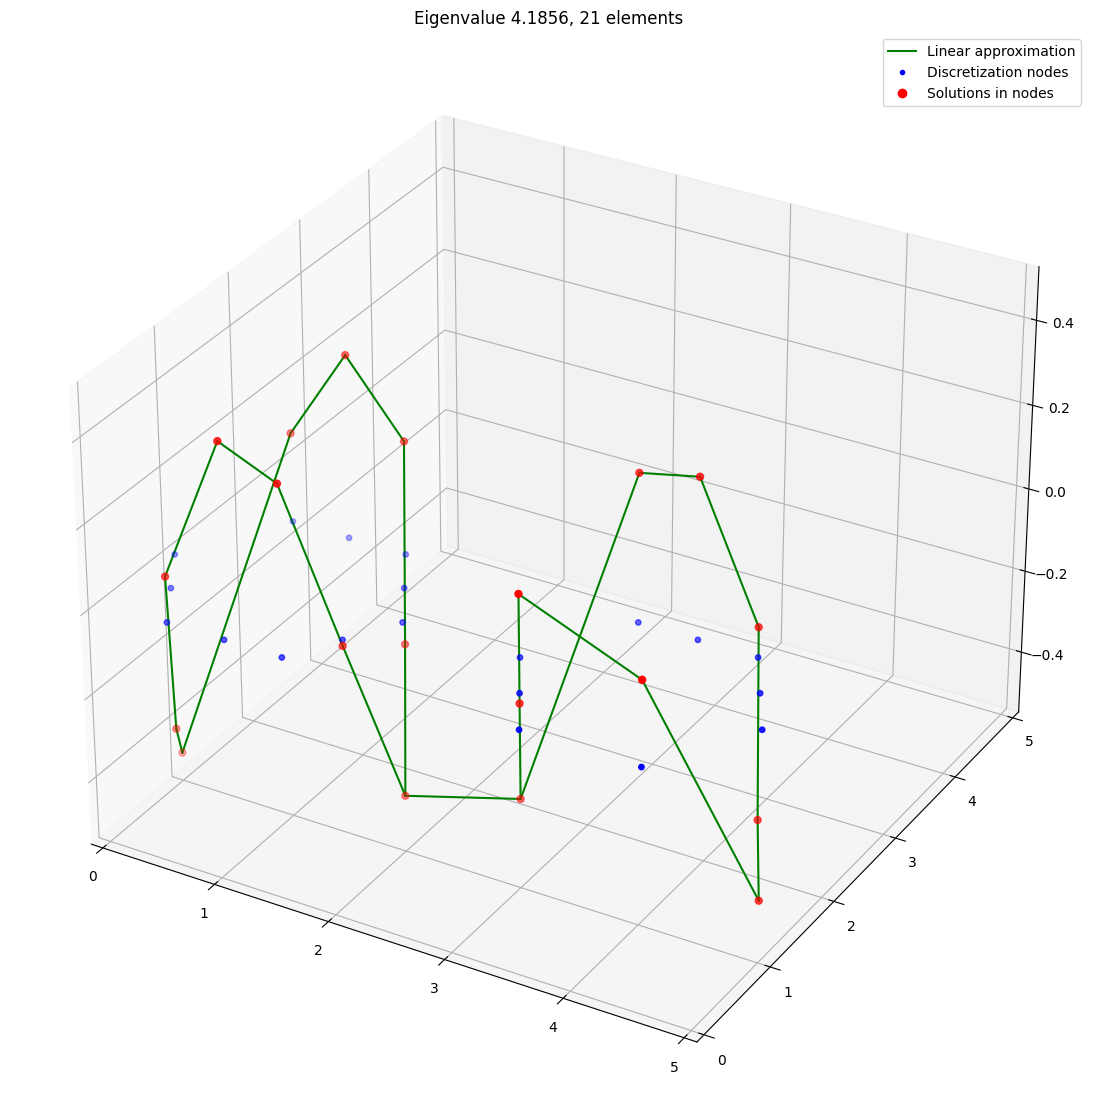

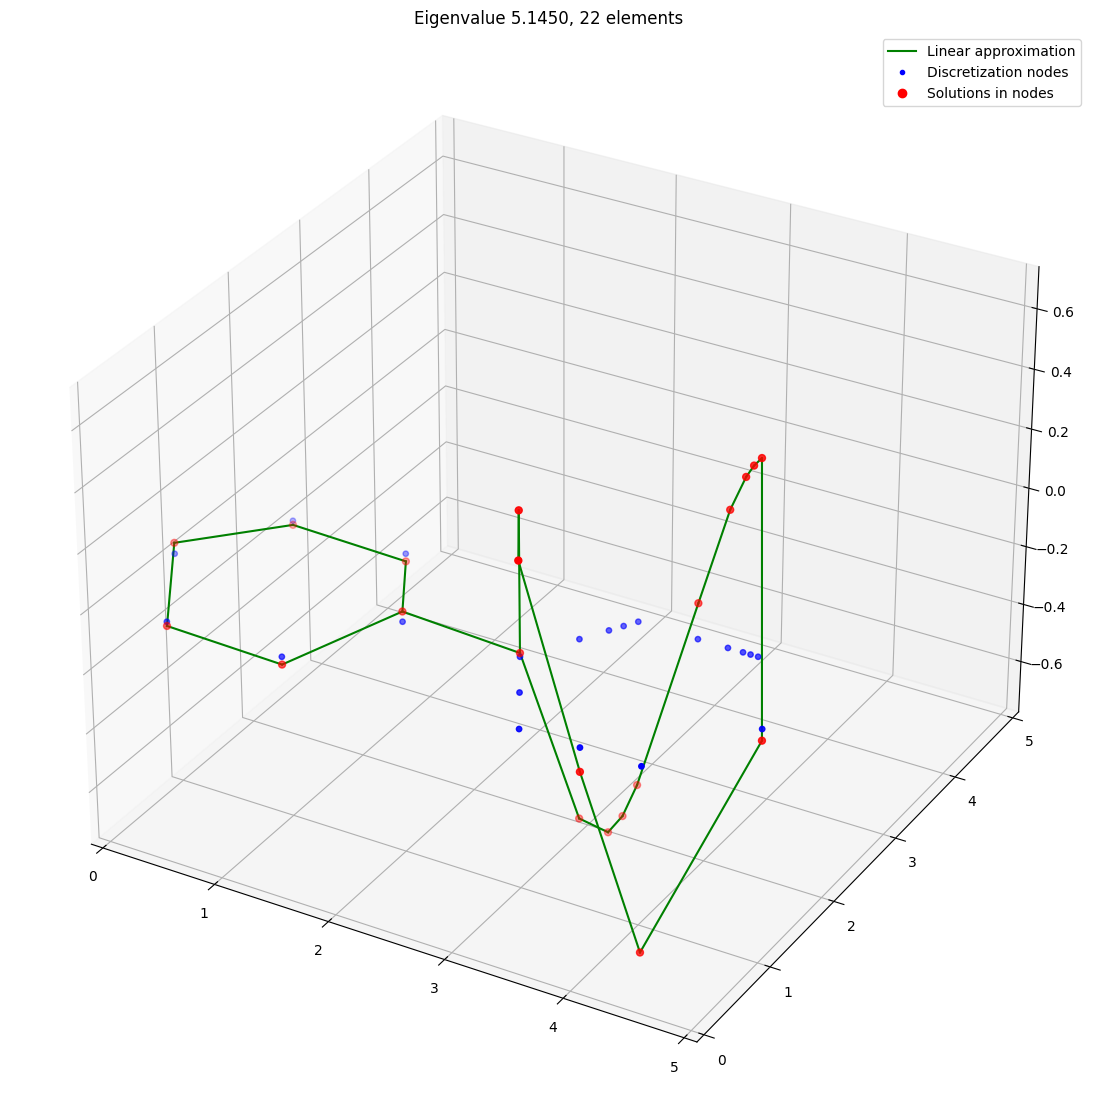

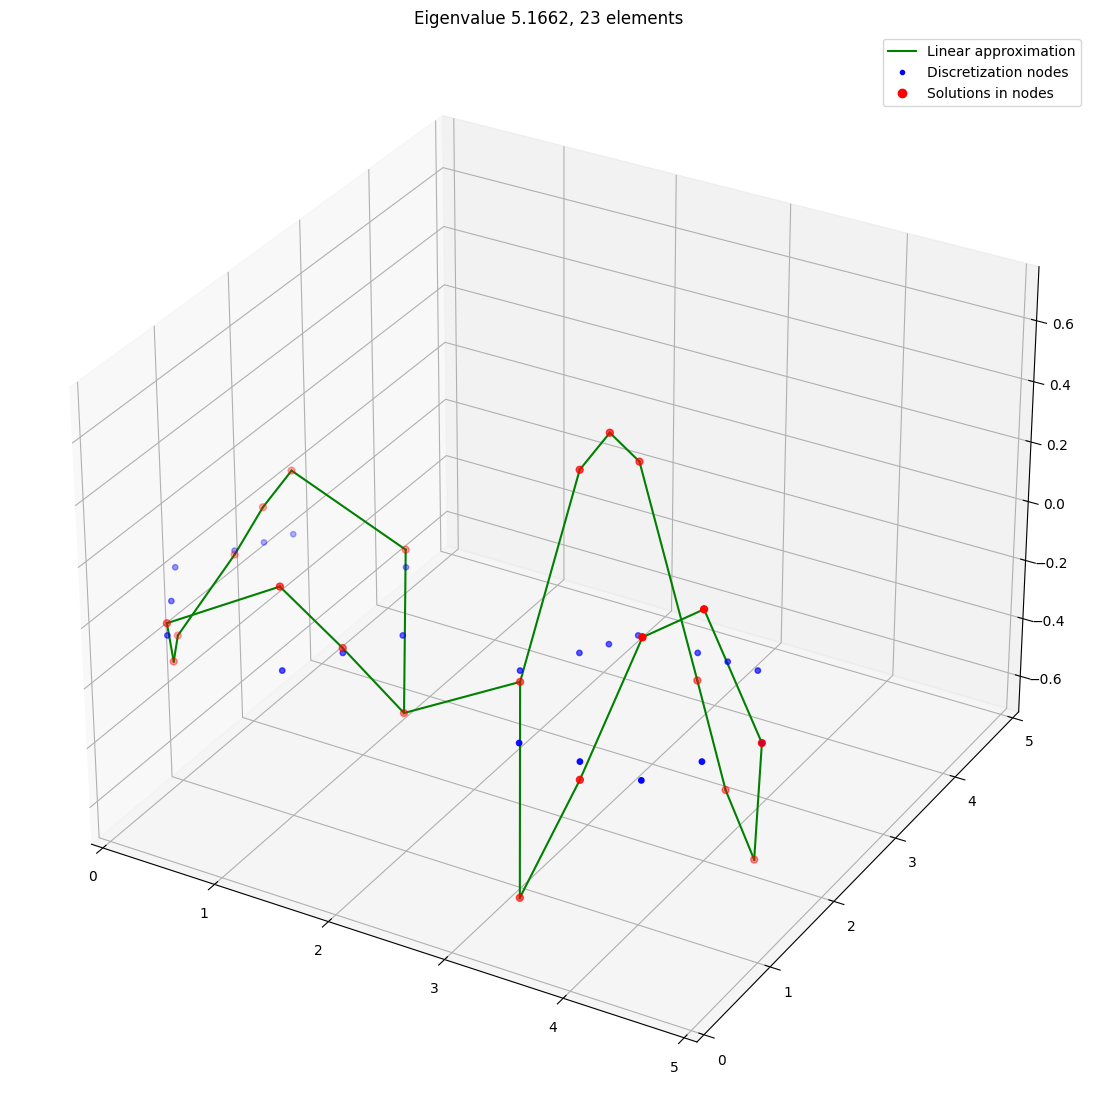

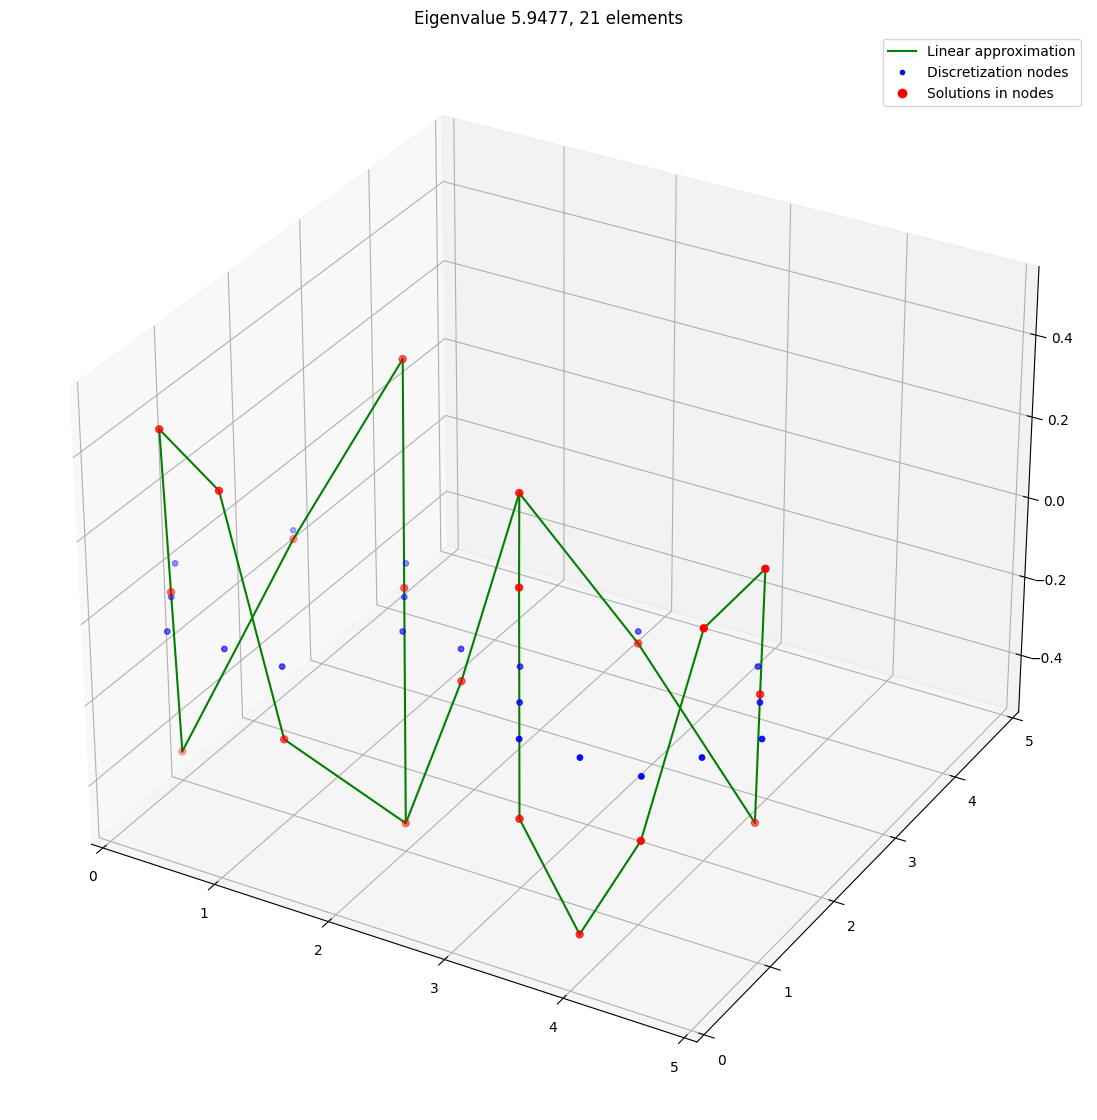

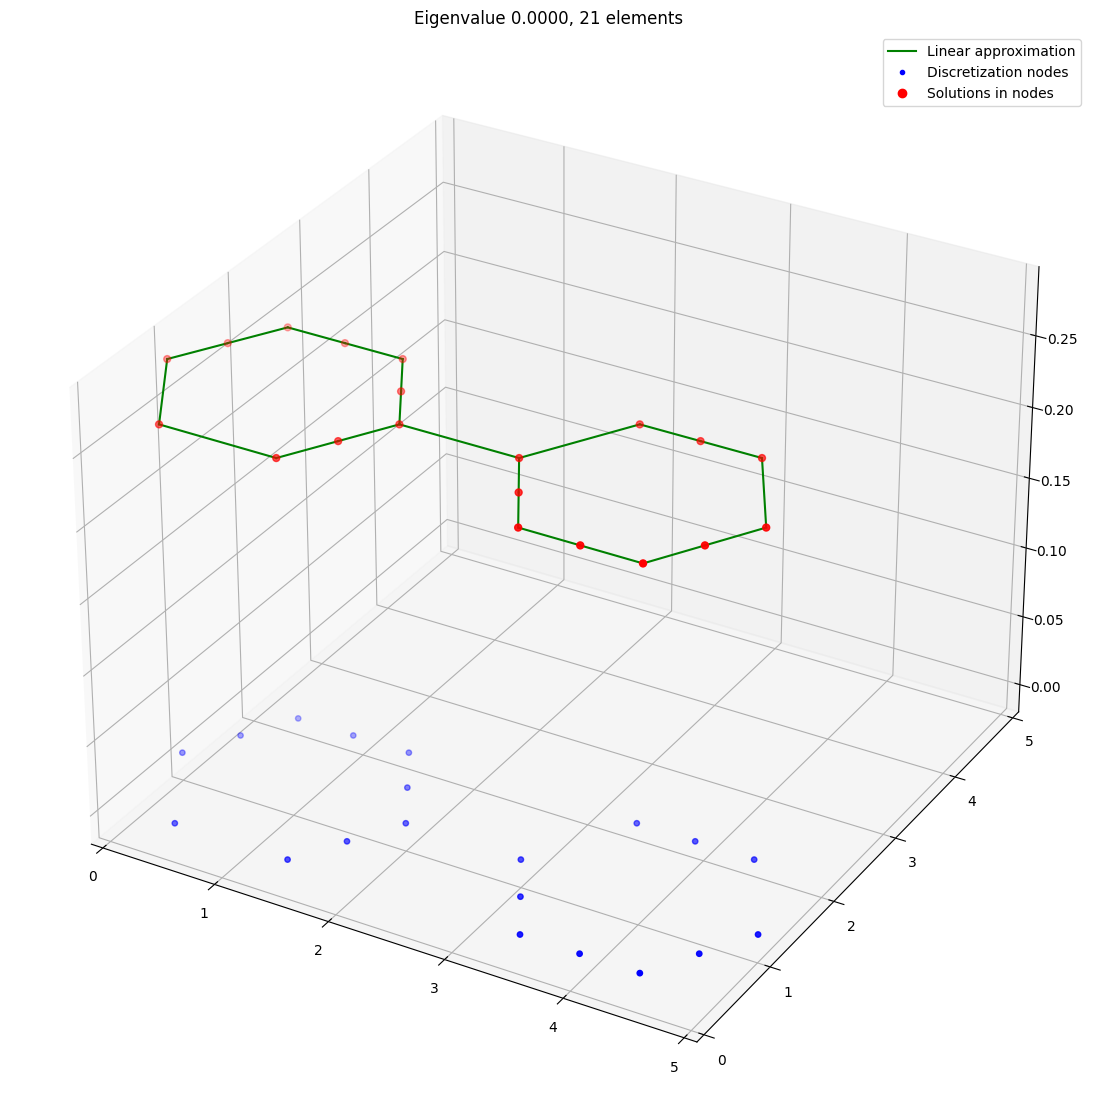

In [24]:
for _ in range(10):
    obs = env.reset()[0]
    for i in range(150):
        action, _state = model.predict(obs, deterministic=True)
        obs, reward, done, trunc, info = env.step(action)
        if done:
            break
    crtaj_eig(env.T)

High value of hyperparameter $\gamma$ made the agent use too few elements.

We will showcase the agent by solving a problem for which the exact solution is <br>
<center>
    $u(x,y)=\sin(2\pi x).$
</center>
<br>
Visible from the graph, refinements on one axis are useless, so it is easy to determine if the agent is making good choices.

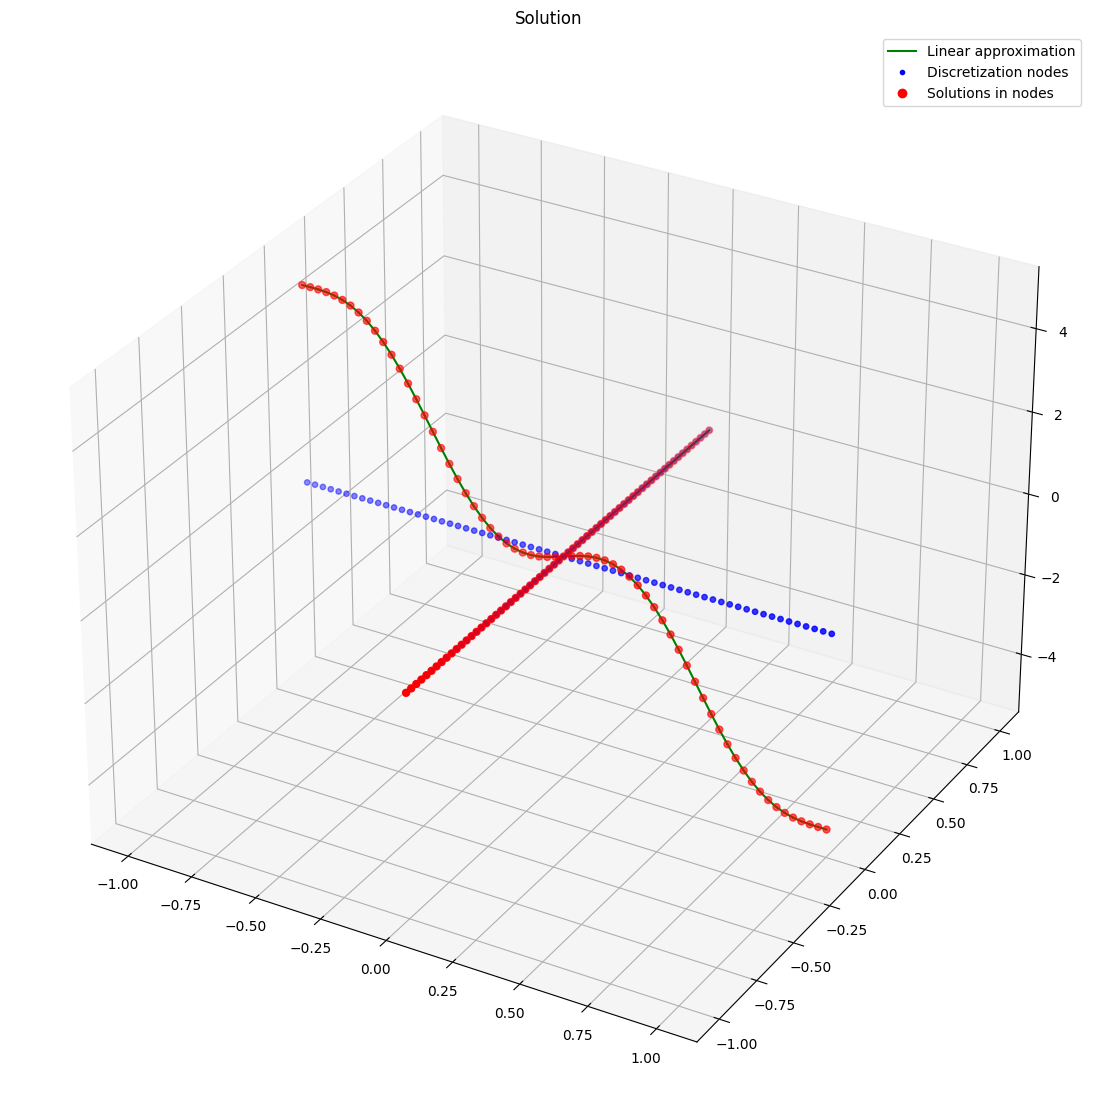

In [26]:
x = Graph(B, featB, fun=primjer)
for _ in range(5):
    for i in range(x.ecnt):
        x.refine(i)
x.calculate()
crtaj_fun(x)

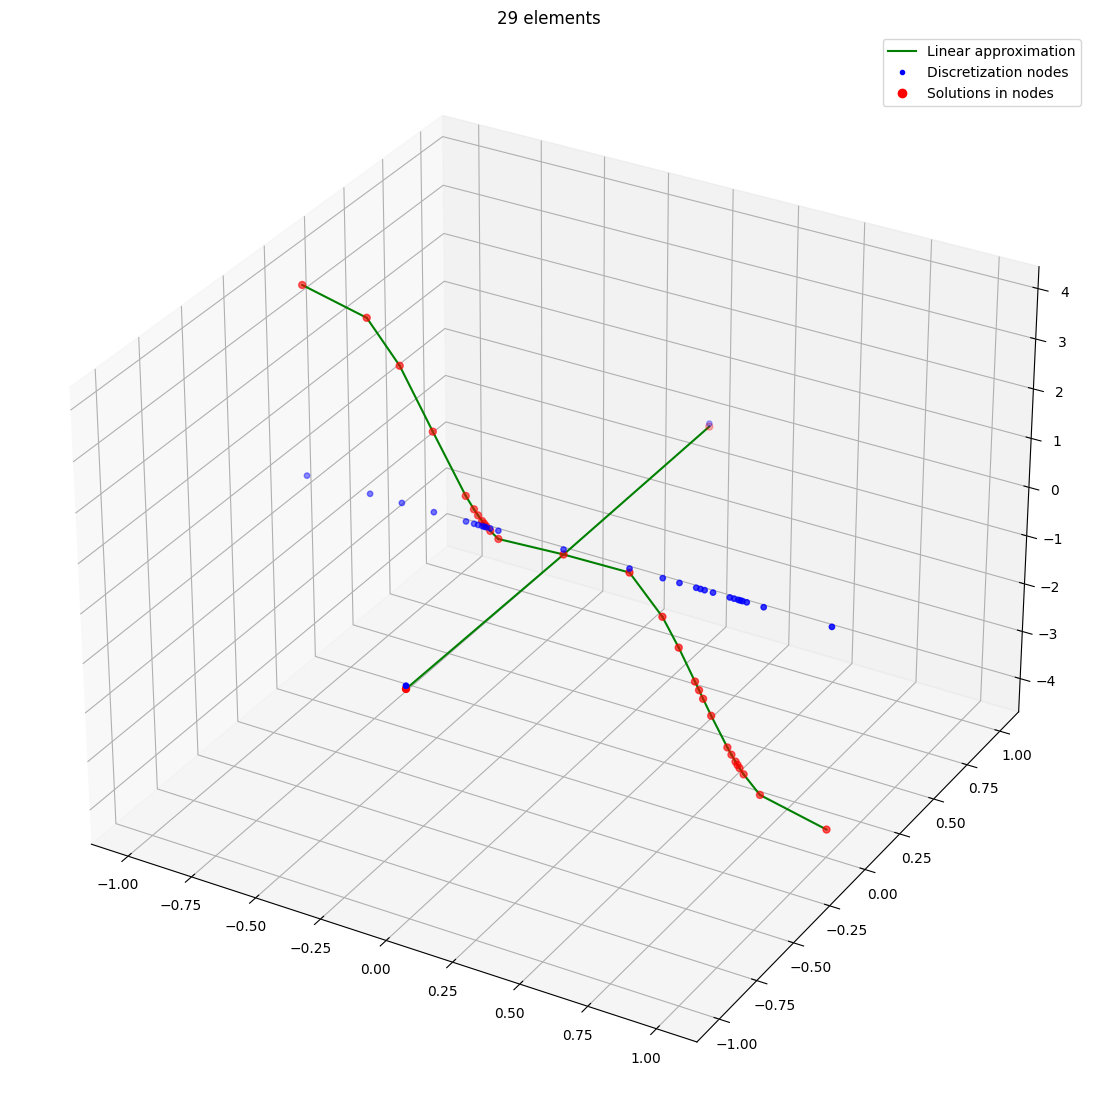

In [35]:
test_env = GraphEnv(Graph(B, featB, fun=primjer))
obs = test_env.reset()[0]
for i in range(150):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, trunc, info = test_env.step(action)
    if done:
        break
crtaj_fun(test_env.T)

As we see, the agent removed all nodes from the axis where the solution is constant.